In [1]:
import numpy as np
import torch
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
from torchviz import make_dot

script_dir = os.getcwd()

from pinnsform.util import *
from pinnsform.model import PINN_old

In [2]:
device = 'cuda'

In [3]:
res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 101, 101)
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

/upb/users/p/pauldf/profiles/unix/cs/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
# Train PINNs 

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = PINN_old(in_dim=2, hidden_dim=512, out_dim=1, num_layer=4).to(device)
model.apply(init_weights)

for param in model.parameters():
    print(param)

optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))

Parameter containing:
tensor([[-0.0218,  0.0036],
        [-0.1027,  0.0951],
        [ 0.0963,  0.0641],
        ...,
        [ 0.0957,  0.0820],
        [-0.0152, -0.0782],
        [-0.0110,  0.1056]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0

In [5]:
loss_track = []

for i in tqdm(range(500)):

    first_call_in_epoch = True
    def closure():
        global first_call_in_epoch
        optim.zero_grad()

        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        
        loss_res = torch.mean((u_t - 5 * pred_res * (1-pred_res)) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)

        if first_call_in_epoch:
            #print(u_t)
            loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])
            first_call_in_epoch = False

        loss = loss_res + loss_bc + loss_ic

        #graph = make_dot(loss)
        #graph.save(os.path.join(script_dir, f"graph_pinn_old_epoch_{i}.dot"))

        
        loss.backward()
        return loss
    
    #memory = torch.cuda.memory_allocated(device)
    #print(f"epoch_{i} GPU-memory", memory)

    optim.step(closure)

100%|██████████| 500/500 [06:57<00:00,  1.20it/s]


In [6]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

torch.save(model.state_dict(), './1dreaction_pinns.pt')

Loss Res: 0.019558, Loss_BC: 0.000004, Loss_IC: 0.179509
Train Loss: 0.199070


In [7]:
loss_track

[[5.342245578765869, 0.3027685284614563, 0.5519466400146484],
 [0.009487023577094078, 1.0236695743515156e-05, 0.19931429624557495],
 [0.011238329112529755, 1.3914122973801568e-05, 0.1970672905445099],
 [0.010960040614008904, 0.00016537429473828524, 0.19591711461544037],
 [0.013403606601059437, 1.320838327956153e-05, 0.1903519183397293],
 [0.015270276926457882, 5.505273747985484e-06, 0.18766412138938904],
 [0.01704372651875019, 0.00013881013728678226, 0.18488696217536926],
 [0.016344062983989716, 0.00011014146730303764, 0.18543179333209991],
 [0.01665526255965233, 9.313723421655595e-05, 0.18501202762126923],
 [0.01718306727707386, 7.643449498573318e-05, 0.18419812619686127],
 [0.017113041132688522, 4.0767077734926715e-05, 0.18426832556724548],
 [0.017559165135025978, 9.378364484291524e-05, 0.18360131978988647],
 [0.017265697941184044, 3.533272320055403e-05, 0.18380193412303925],
 [0.017472177743911743, 3.817670585704036e-05, 0.18349139392375946],
 [0.01735370233654976, 4.211685518384911

In [7]:
loss_track

[[5.342245578765869, 0.3027685284614563, 0.5519466400146484],
 [0.009487023577094078, 1.0236695743515156e-05, 0.19931429624557495],
 [0.011238329112529755, 1.3914122973801568e-05, 0.1970672905445099]]

relative L1 error: 0.978331
relative L2 error: 0.977197


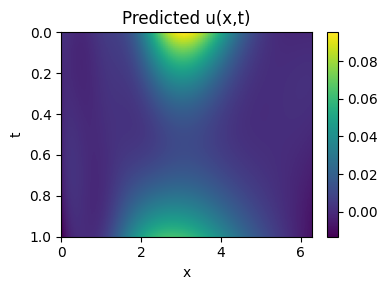

In [7]:
# Visualize PINNs 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

def h(x):
    return np.exp( - (x-np.pi)**2 / (2 * (np.pi/4)**2))

def u_ana(x,t):
    return h(x) * np.exp(5*t) / ( h(x) * np.exp(5*t) + 1 - h(x))

res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)
u = u_ana(res_test[:,0], res_test[:,1]).reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_pinns_pred.png')
plt.show()

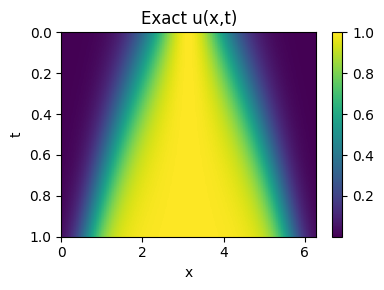

In [8]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_exact.png')
plt.show()

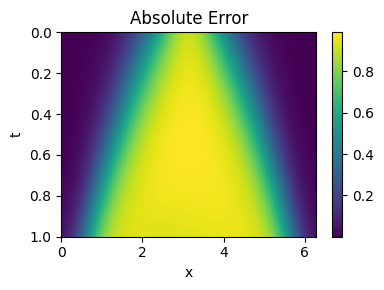

In [9]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_pinns_error.png')
plt.show()